## UWUe Benchmarks
### NVCS (N-Gram Vector Cosine Similarity)
- See how similar two texts' writing styles are using Character N-Grams (sequence of characters and punctuations). 
- Converts the Sample Dialogues and the Generated Response into Character N-Gram Vectors in which Cosine Similarity will be calculated. 
 - 1.0 means exactly the same, 0.0 means no similarity at all. The higher the NVCS, the better the LLM can copy the Chatbot's writing style from Sample Dialogues -> Generated Responses.
 
$$ nvcs(D, R) = \frac{\sum{i=1}^{n}D{i}R{i}}{\sqrt{\sum{i=1}^{n}D{i}^{2}}\cdot\sqrt{\Sigma{i=1}^{n}R_{i}^{2}}} $$
<div align="center">
D = User's Sample Dialogues as Vectorized Character N-Gram <br>
R = LLM's Generated Responses as Vectorized Character N-Gram
</div>

 ### ERTD (English Readability Transfer Difference)
- See how different the English readability scores are between two texts
- Absolute value of the difference between the English Readability of the Sample Dialogues and English Readability of Generated Responses. Formula to be used is Flesch-Kincaid Reading Ease.
- The lower the ERTD, the better the LLM can adapt the Text Difficulty seen in the User’s Sample Dialogues into its Generated Responses
- Value is clamped to 0 to 100 for edge cases where Flesch-Kincaid returns values outside of expected boundary

$$Fk_t=206.835 - 1.015 * (ASL_t) - 84.6 * (ASW_t)$$
$$Er_t= \begin{cases}
100, & \text{if } Fk_t > 100 \\
Fk_t, & \text{if } Fk_t > 0 \\
0, & \text{otherwise}
\end{cases}$$
<div align="center">
Fk<sub>t</sub> = Flesch-Kincaid Reading Ease of Text t<br>
Er<sub>t</sub> = English Readability of Text t<br>
ASL = Total Words in Text / Total Sentences in Text t<br>
ASW = Total Syllables in Text / Total Words in Text t
</div>
<br>

$$ertd(Er_d,Er_r) = |Er_d - Er_r|$$
<div align="center">
Er<sub>d</sub> = English Readability of User's Sample Dialogues <br>
Er<sub>r</sub> = English Readability of LLM's Generated Responses
</div>

### JERA (Judgement Evaluation on Roleplay Ability)
- Using LLM-as-Judge (which is popularly used in other benchmark tools), evaluate how well the LLM Roleplays in general, using a 10-point Likert Scale questionnaire consisting of 10 items each for 3 different metrics, (1) Immersivity, (2) Consistency, (3) and Creativity:
- **Immersivity**: Evaluates how well the LLM can immerse the user in the roleplay, making the experience enjoyable and engaging. This includes staying in character, reacting appropriately to scenarios, and maintaining a believable and captivating narrative.
- **Consistency**: Assesses the LLM's ability to stay true to the character throughout the roleplay. This involves maintaining the character's personality, background, mannerisms, and speech style without breaking character or deviating from the established persona.
- **Creativity:** Measures the LLM's ability to generate unique and dynamic responses, avoiding redundancy. This includes creating interesting dialogue, actions, and scenarios that keep the roleplay fresh and engaging.
- The Judge LLM is provided the Attribute List and Sample Dialogues as well, to help with the evaluation.
- Judge LLM answers a questionnaire as if they were a human evaluating and testing the UWU Chatbot for Roleplaying. JERA is the total score returned.
- The higher the JERA score, the better the LLM can Roleplay in general as perceived by an outside evaluator. Total score returned is 300.

$$jera(Rp) = Imm_{\text{Rp}}+Con_{\text{Rp}}+Cre_{\text{Rp}}$$
<div align="center">
Rp = LLM's Generated Roleplay Scene<br>
Imm<sub>Rp</sub> = LLM's evaluated Immersivity score during Roleplay<br>
Con<sub>Rp</sub> = LLM's evaluated Consistency score during Roleplay<br>
Cre<sub>Rp</sub> = LLM's evaluated Creativity score during Roleplay<br>
</div>




### ALMP (Attribute List Match Percentage)
- See how much percent of the Attribute List can be observed in the Roleplay Scene generated by the LLM
- Looks for matches between the set of attributes observed in the Attribute List and the set of attributes observed in the Roleplay Scene. Observations are found through an Extraction model and an Inference model working together.
- The higher the ALMP, the better the LLM applied the User's Attribute List into its roleplaying.
- Value returned is 0.0-1.0.

$$
\text{almp(A,R)} = \frac{M}{\text{count(A)}}
$$
$$M = \sum_{i=1}^{A} \text{Match}(a_i, R)$$
<div align="center">
M = Total number of matched attributes between Attribute List set A and Roleplay Scene set R<br>
Match(a<sub>i</sub>, R) = Function to determine if the attribute a<sub>i</sub> matches any attribute in R
</div>
<br>

$$
\text{Match}(a_i, R) = 
\begin{cases} 
1 & \text{if } a_i \in R \quad  \\
1 & \text{if } \text{FuzzyRatio}(a_i, r) > 85, \quad \forall r \in R \quad  \\
1 & \text{if } \text{SynSet}(a_i) \cap \text{SynSet}(r) \neq \emptyset, \quad \forall r \in R \quad  \\
0 & \text{otherwise}
\end{cases}
$$
<div align="center">
Match(a<sub>i</sub>, R) = Determines if the attribute a<sub>i</sub> from the Attribute List matches any attribute in the Roleplay Scene set R.<br>
a<sub>i</sub> = An attribute from the Attribute List.<br>
R = Set of attributes extracted from the Roleplay Scene.<br>
FuzzyRatio(a<sub>i</sub>, r) = Levenshtein-based similarity ratio between attributes a<sub>i</sub> and r.<br>
SynSet(a<sub>i</sub>) = Set of synonyms for attribute a<sub>i</sub> generated using WordNet.<br>
r = An attribute from the Roleplay Scene set R.
</div>
<br>



## 1. Load Data into Benchmark Tool

In [2]:
from datahelper import DataHelper

# Load the config file
config = DataHelper.load_config('./config.ini') 

# Load all characters from directory into a Character Object array
characters = DataHelper.load_character_directory('./characters', config) 

## 2. Roleplay Scene Generation

In [3]:
from llms.gpt import GPT
from llms.claude import Claude
from llms.gemini import Gemini
from llms.novelai import NovelAI

# For each character, produce roleplay scenes
if config.test_llm.startswith('gpt'):
    for character in characters:
        character.rpscene = GPT.generate_roleplay(character, config)
elif config.test_llm.startswith('claude'):
    for character in characters:
        character.rpscene = Claude.generate_roleplay(character, config)
elif config.test_llm.startswith('gemini'):
    for character in characters:
        character.rpscene = Gemini.generate_roleplay(character, config)
else:
    for character in characters:
        character.rpscene = await NovelAI.generate_roleplay(character, config)

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Character: Camille
Attributes: Camille Fleur is a 22-year-old French girl (55 kg) known for her radiant charm and carefree personality.  She stands at 165 cm tall, with golden-blonde hair styled into braided twin tails that bounce as  she moves, adorned with a flower-shaped hairpin. Her warm golden eyes light up her delicate, pale complexion,  and her playful smile often reveals a small, adorable fang. Camille’s style reflects her fun and trendy  personality, wearing a pink knit off-shoulder sweater, a chic black plaid skirt, and a black choker  that contrasts her skin. She carries a small yellow handbag that completes her vibrant yet effortless look.  Camille is lighthearted, spontaneous, and deeply affectionate, often teasing and doting on {{user}},  whom she has been dating for over a year. She’s highly agreeable and rarely takes things seriously,  brushing off negativity with a laugh or pouty face. Camille adores sweets, spontaneous dates, and  romantic comedies but dislikes long, 

## 3. Benchmark Evaluation

In [ ]:
from algorithms.nvcs import NVCS
from algorithms.ertd import ERTD
from algorithms.jera import JERA
from algorithms.almp import ALMP
from algorithms.uwu import UWU
from datahelper import DataHelper

import datetime
import statistics as st

# Initialize benchmark algorithms
nvcs, ertd, jera, almp, uwu = NVCS(), ERTD(), JERA(), ALMP(), UWU()
nvcs_scores, ertd_scores, jera_scores, almp_scores, uwu_scores, character_evals = [], [], [], [], [], []

# Use generated responses to calculate benchmark scores
characters = DataHelper.load_generations_directory('./generations')
config = DataHelper.load_config('./config.ini') 

# For each LLM, gather the average benchmark scores based on all Characters
for character in characters:

    # Get all test character's utterances from sample dialogues as single string, separated by spaces, excluding the character's name
    charaOnlySampleDialogues = " ".join([dialogue.split(": ", 1)[1] for dialogue in character.smpdialogues if dialogue.startswith(f"{character.name}:")]) 
    # Get all test character's utterances from generated responses as single string, separated by spaces, excluding the character's name
    charaOnlyGeneratedResponses = " ".join([response.split(": ", 1)[1] for response in character.rpscene if response.startswith(f"{character.name}:")]) 
    # Get all roleplay dialogue between the test character and user character as single string, separated by newlines, including character's name
    fullRoleplay = "\n".join(character.rpscene) 

    print(f"========================== Benchmarking using {character.name}... ==========================\n")
    
    nvcs_score = nvcs.calculate_nvcs(config.ngram, charaOnlySampleDialogues, charaOnlyGeneratedResponses) # Return calculated NVCS as Float value
    print(f"- NVCS Score: {nvcs_score:.2f} out of 1.0\n")

    ertd_score = ertd.calculate_ertd(charaOnlySampleDialogues, charaOnlyGeneratedResponses)
    print(f"- ERTD Score: {ertd_score:.2f} out of 100\n")
    
    jera_score = jera.calculate_jera(character.name, character.attributes, character.smpdialogues, fullRoleplay, config)
    print(f"- JERA Score: {jera_score} out of 300\n")

    almp_score = almp.calculate_almp(character.attributes, charaOnlyGeneratedResponses, config)
    print(f"- ALMP Score: {almp_score:.2f} out of 1.0\n")

    uwu_score = uwu.calculate_uwu_score(nvcs_score, ertd_score, jera_score, almp_score)
    print(f"- UwU Score: {uwu_score:.2f} out of 100\n")

    nvcs_scores.append(nvcs_score)
    ertd_scores.append(ertd_score)
    jera_scores.append(jera_score)
    almp_scores.append(almp_score)
    uwu_scores.append(uwu_score)

    # Save scores unto character_evals
    character_evals.append(
        {
            'character': {
                'scores': {
                    'nvcs': nvcs_score,
                    'ertd': ertd_score,
                    'jera': jera_score,
                    'almp': almp_score,
                    'uwu': uwu_score
                },
                'name': character.name
            }
        }
            
    )

print(f"========================== Benchmarking all characters accomplished, now saving... ==========================")

# Save Benchmark results to file
benchmark_results = {
    'date_generated': datetime.datetime.now().strftime("%Y%m%d_%H%M"),
    'results': {
        'avg_scores': { # Average results
            'nvcs': st.mean(nvcs_scores),
            'ertd': st.mean(ertd_scores),
            'jera': st.mean(jera_scores),
            'almp': st.mean(almp_scores),
            'uwu': st.mean(uwu_scores)
        },
        'max_scores': { # Best results
            'nvcs': max(nvcs_scores),
            'ertd': max(ertd_scores),
            'jera': max(jera_scores),
            'almp': max(almp_scores),
            'uwu': max(uwu_scores)
        },
        'min_scores': { # Worst results
            'nvcs': min(nvcs_scores),
            'ertd': min(ertd_scores),
            'jera': min(jera_scores),
            'almp': min(almp_scores),
            'uwu': min(uwu_scores)
        },
        'std_devs': { # Standard Deviations of results
            'nvcs': st.stdev(nvcs_scores) if len(nvcs_scores) > 1 else 0,
            'ertd': st.stdev(ertd_scores) if len(ertd_scores) > 1 else 0,
            'jera': st.stdev(jera_scores) if len(jera_scores) > 1 else 0,
            'almp': st.stdev(almp_scores) if len(almp_scores) > 1 else 0,
            'uwu': st.stdev(uwu_scores) if len(uwu_scores) > 1 else 0
        }
    },
    'config': {
        'ngram': config.ngram,
        'smp_dialogues_max': config.smp_dialogues_max,
        'test_llm': config.test_llm,
        'rp_turns': config.rp_turns,
        'user_name': config.user_name
    },
    'characount': len(characters),
    'characters_used': character_evals
}

DataHelper.save_results(benchmark_results)

========================== Benchmarking using Camille... ==========================

Sample Dialogue's N-Grams: [0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 4, 4, 0, 0, 0, 4, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 5, 0, 0, 1, 0, 1, 0, 0, 1, 7, 2, 0, 1, 0, 0, 2, 1, 4, 0, 0, 0, 5, 2, 0, 3, 2, 0, 1, 2, 0, 2, 1, 4, 2, 1, 2, 1, 2, 1, 1, 0, 4, 1, 1, 0, 1, 1, 0, 3, 1, 1, 3, 0, 1, 3, 0, 3, 7, 0, 2, 1, 0, 0, 3, 0, 0, 0, 1, 4, 5, 5, 1, 0, 3, 2, 0, 1, 1, 4, 0, 6, 1, 4, 0, 2, 4, 0, 0, 0, 1, 0, 3, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 2, 4, 1, 1, 1, 1, 4, 2, 2, 0, 0, 2, 10, 2, 7, 1, 1, 1, 1, 1, 0, 1, 0, 2, 0, 2, 3, 1, 0, 8, 0, 1, 1, 0, 1, 0, 2, 0, 1, 5, 0, 2, 2, 0, 5, 0, 2, 0, 1, 1, 0, 2, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 1, 1, 3, 0, 2, 4, 1, 1, 1, 3, 0, 0, 3, 0, 1, 3, 2, 0, 1, 3, 1, 2, 3, 0, 0, 10, 1, 0, 0, 1, 0, 0, 1, 2, 2, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 5, 0, 0, 1, 0, 0, 1, 1, 2, 5, 0, 2, 0, 4, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 

# Visualization of Results Folder
Requires multiple results from different LLMs.

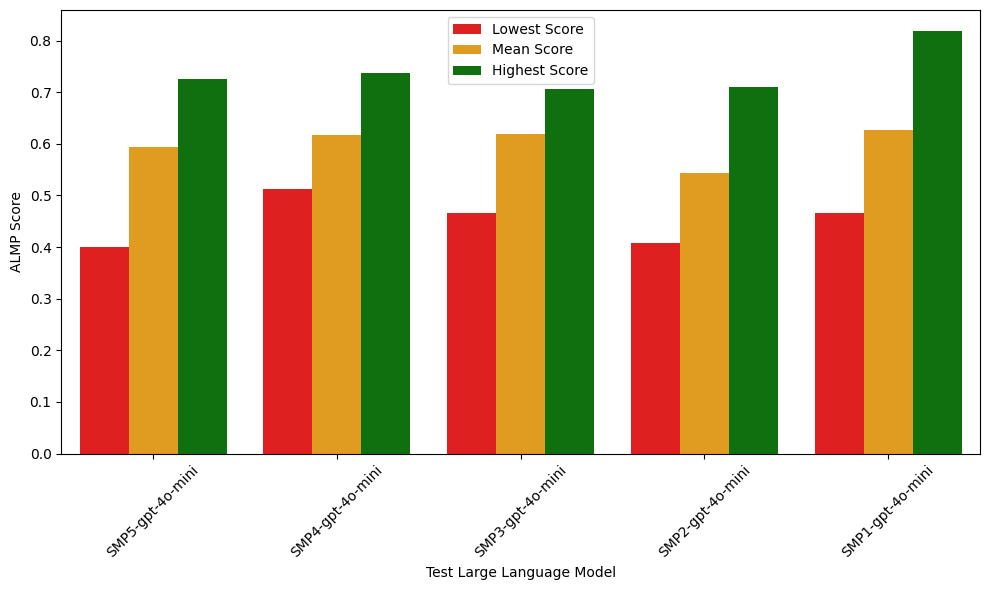

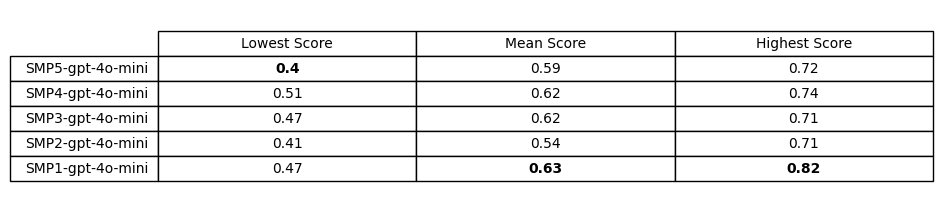

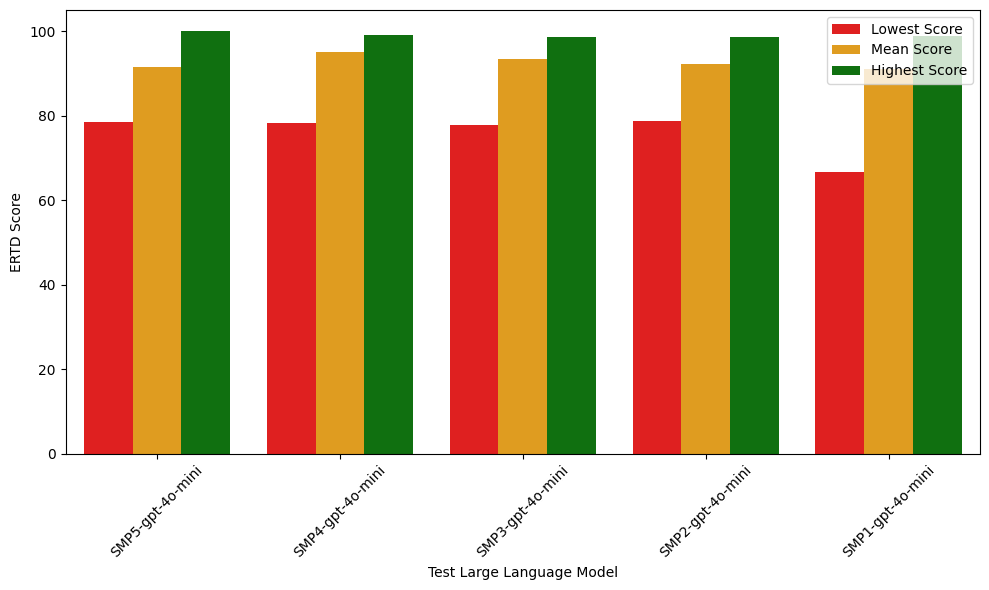

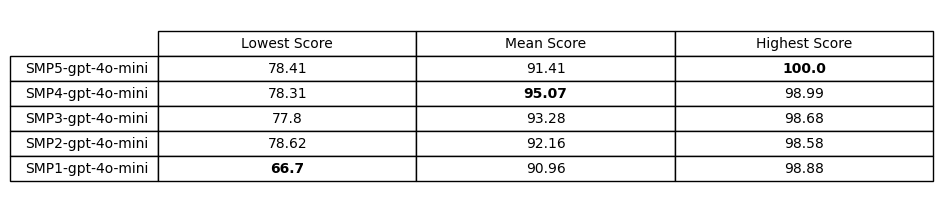

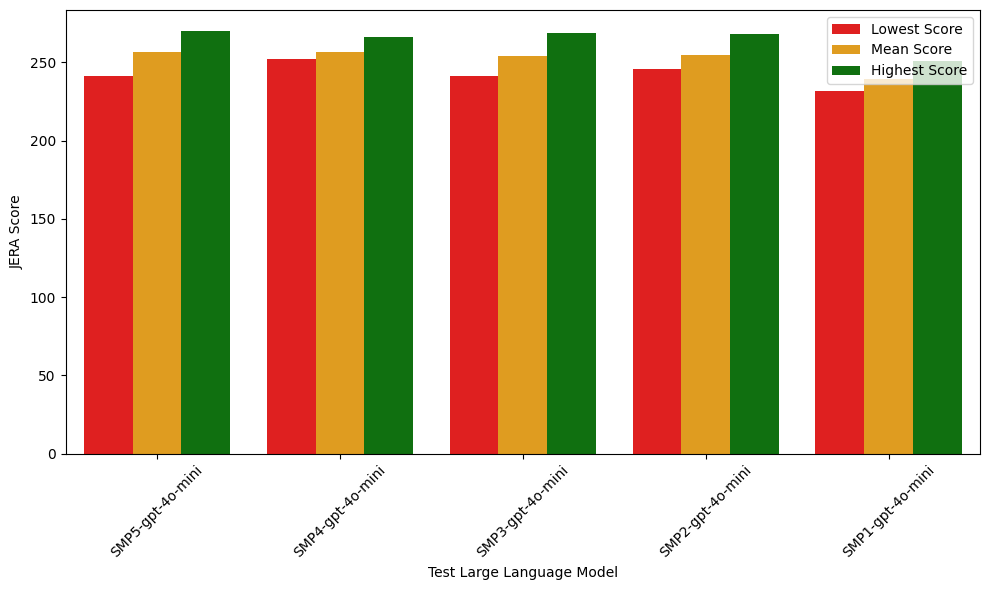

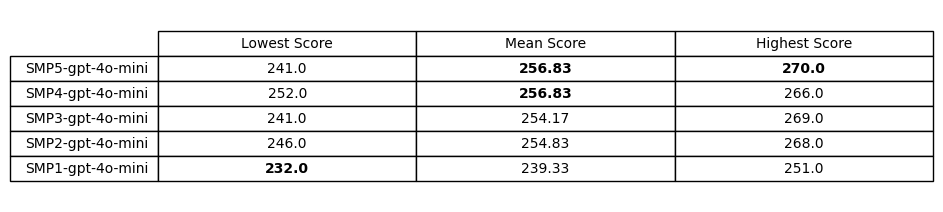

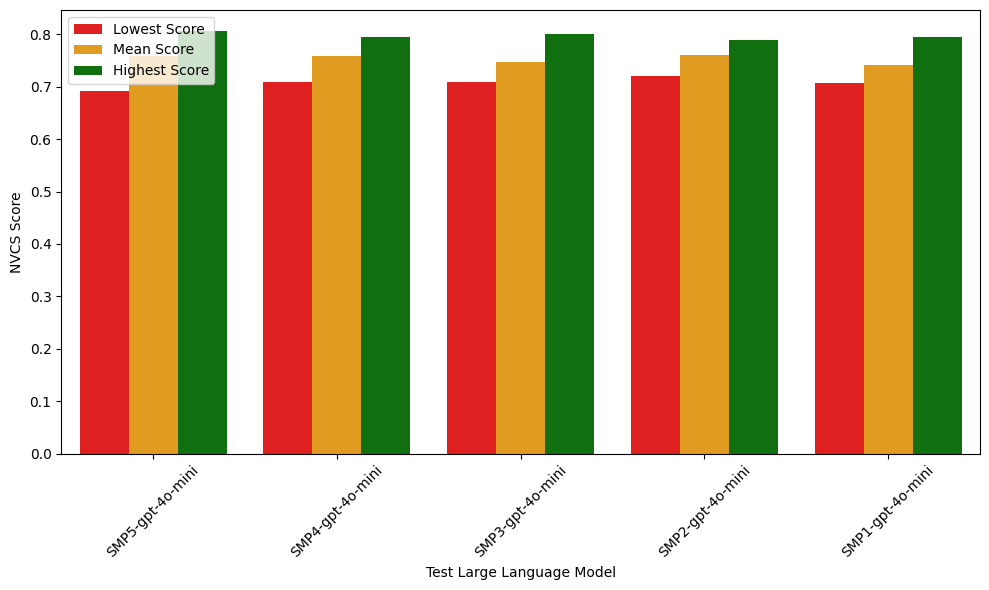

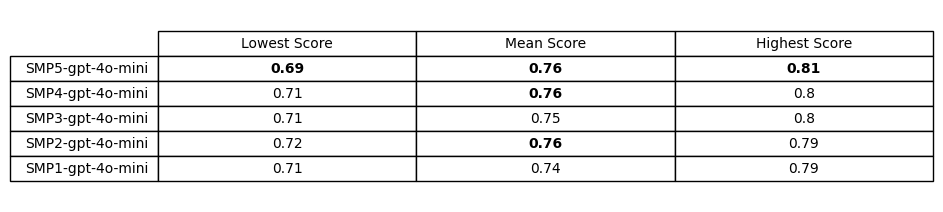

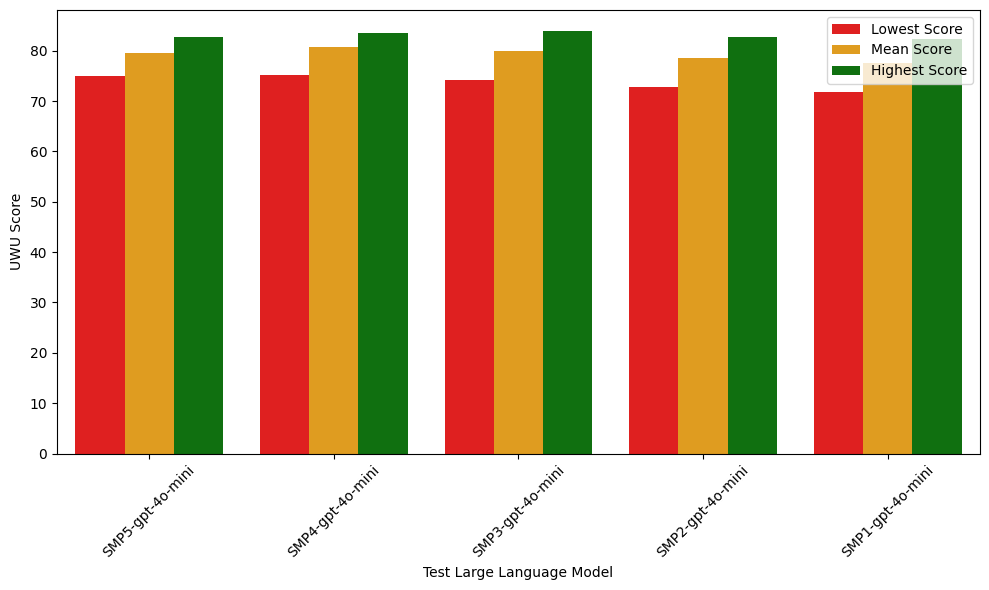

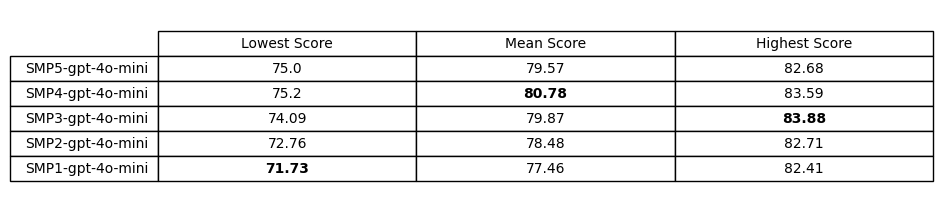

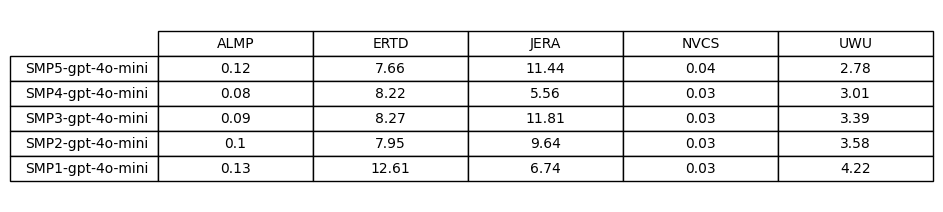

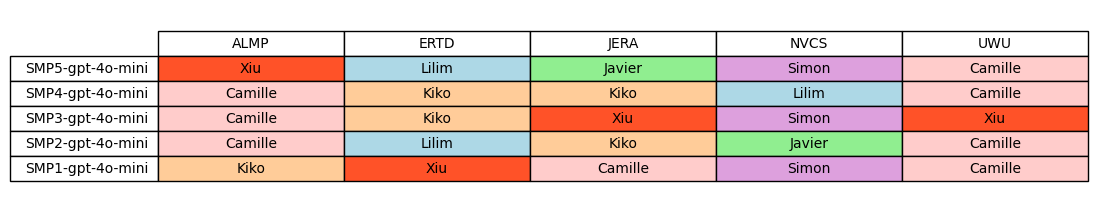

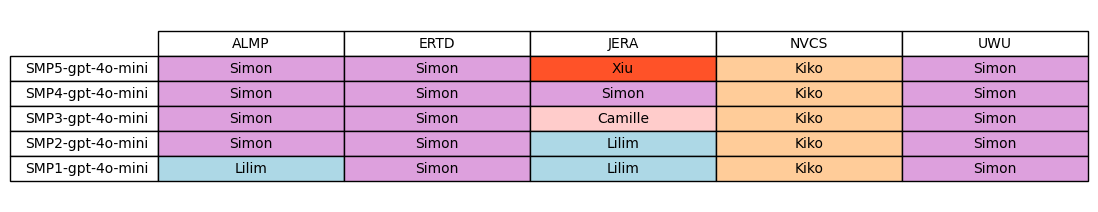

LaTeX code for Average Scores Table:
\begin{table}
\caption{Average Scores}
\label{average_scores}
\begin{tabular}{lrrrrr}
\toprule
LLM & ALMP & ERTD & JERA & NVCS & UWU \\
\midrule
SMP5-gpt-4o-mini & 0.59 & 91.41 & \textbf{256.83} & \textbf{0.76} & 79.57 \\
SMP4-gpt-4o-mini & 0.62 & \textbf{95.07} & \textbf{256.83} & \textbf{0.76} & \textbf{80.78} \\
SMP3-gpt-4o-mini & 0.62 & 93.28 & 254.17 & 0.75 & 79.87 \\
SMP2-gpt-4o-mini & 0.54 & 92.16 & 254.83 & \textbf{0.76} & 78.48 \\
SMP1-gpt-4o-mini & \textbf{0.63} & 90.96 & 239.33 & 0.74 & 77.46 \\
\bottomrule
\end{tabular}
\end{table}


LaTeX code for Maximum Scores Table:
\begin{table}
\caption{Maximum Scores}
\label{maximum_scores}
\begin{tabular}{lrrrrr}
\toprule
LLM & ALMP & ERTD & JERA & NVCS & UWU \\
\midrule
SMP5-gpt-4o-mini & 0.72 & \textbf{100.00} & 270 & \textbf{0.81} & 82.68 \\
SMP4-gpt-4o-mini & 0.74 & 98.99 & 266 & 0.80 & 83.59 \\
SMP3-gpt-4o-mini & 0.71 & 98.68 & 269 & 0.80 & \textbf{83.88} \\
SMP2-gpt-4o-mini & 0.71 & 98.58 &

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datahelper import DataHelper

# Load all results from results folder
results = DataHelper.load_results_directory('./results')

# Initialize lists to store data
avg_data = []
max_data = []
min_data = []
std_dev_data = []
best_performers = []
worst_performers = []

# Define the metrics
metrics = ['ALMP', 'ERTD', 'JERA', 'NVCS', 'UWU']

# Define custom LLM order
# llm_order = ['gpt-4o', 'gpt-4o-mini', 'gpt-3.5-turbo', 'claude-3-5-sonnet', 'claude-3-5-haiku', 'claude-3-haiku', 'nai-kayra', 'nai-clio']
# llm_order = ['PT-gpt-4o-mini', 'SO-gpt-4o-mini', 'CA-gpt-4o-mini']
llm_order = ['SMP5-gpt-4o-mini', 'SMP4-gpt-4o-mini', 'SMP3-gpt-4o-mini', 'SMP2-gpt-4o-mini', 'SMP1-gpt-4o-mini']



# Function to clean Claude model names
def clean_claude_name(name):
    if name.startswith('claude-3-haiku'):
        return 'claude-3-haiku'
    elif name.startswith('claude'):
        parts = name.split('-')
        return '-'.join(parts[:4])
    return name

# Clean LLM order
llm_order = [clean_claude_name(llm) for llm in llm_order]

for result in results:
    avg_scores = result.results['avg_scores']
    max_scores = result.results['max_scores']
    min_scores = result.results['min_scores']
    std_devs = result.results['std_devs']
    test_llm = clean_claude_name(result.config.test_llm)  # Ensure LLM label uses correct name

    # Append data for each metric and LLM
    avg_data.append([test_llm] + [avg_scores[metric.lower()] for metric in metrics])
    max_data.append([test_llm] + [max_scores[metric.lower()] for metric in metrics])
    min_data.append([test_llm] + [min_scores[metric.lower()] for metric in metrics])
    std_dev_data.append([test_llm] + [round(std_devs[metric.lower()], 2) for metric in metrics])

    # Find the best and worst character for each metric in this result
    best_character = {metric.lower(): None for metric in metrics}
    worst_character = {metric.lower(): None for metric in metrics}
    best_score = {metric.lower(): float('-inf') for metric in metrics}
    worst_score = {metric.lower(): float('inf') for metric in metrics}

    for character in result.characters:
        for metric, score in character.scores.items():
            if score > best_score[metric]:
                best_score[metric] = score
                best_character[metric] = character.name
            if score < worst_score[metric]:
                worst_score[metric] = score
                worst_character[metric] = character.name

    best_performers.append([test_llm] + [best_character[metric.lower()] for metric in metrics])
    worst_performers.append([test_llm] + [worst_character[metric.lower()] for metric in metrics])

# Convert to DataFrames for easy plotting and table creation
avg_df = pd.DataFrame(avg_data, columns=['LLM'] + metrics)
max_df = pd.DataFrame(max_data, columns=['LLM'] + metrics)
min_df = pd.DataFrame(min_data, columns=['LLM'] + metrics)
std_df = pd.DataFrame(std_dev_data, columns=['LLM'] + metrics)
best_df = pd.DataFrame(best_performers, columns=['LLM'] + metrics)
worst_df = pd.DataFrame(worst_performers, columns=['LLM'] + metrics)

# Ensure all DataFrames have the same LLM order
avg_df['LLM'] = pd.Categorical(avg_df['LLM'], categories=llm_order, ordered=True)
max_df['LLM'] = pd.Categorical(max_df['LLM'], categories=llm_order, ordered=True)
min_df['LLM'] = pd.Categorical(min_df['LLM'], categories=llm_order, ordered=True)
std_df['LLM'] = pd.Categorical(std_df['LLM'], categories=llm_order, ordered=True)
best_df['LLM'] = pd.Categorical(best_df['LLM'], categories=llm_order, ordered=True)
worst_df['LLM'] = pd.Categorical(worst_df['LLM'], categories=llm_order, ordered=True)

avg_df.sort_values('LLM', inplace=True)
max_df.sort_values('LLM', inplace=True)
min_df.sort_values('LLM', inplace=True)
std_df.sort_values('LLM', inplace=True)
best_df.sort_values('LLM', inplace=True)
worst_df.sort_values('LLM', inplace=True)

# Function to plot grouped bar graphs for each metric
def plot_grouped_bars(metric):
    plt.figure(figsize=(10, 6))

    # Build bar_data DataFrame for the given metric
    bar_data = pd.DataFrame({
        'LLM': avg_df['LLM'],
        'Lowest Score': min_df[metric],
        'Mean Score': avg_df[metric],
        'Highest Score': max_df[metric]
    })

    # Melt the DataFrame for seaborn plotting
    bar_data_melted = bar_data.melt(id_vars='LLM', var_name='Legend', value_name=f'{metric} Score')

    # Define the palette with specified colors
    palette = {'Lowest Score': 'red', 'Mean Score': 'orange', 'Highest Score': 'green'}

    # Create the bar plot
    sns.barplot(
        x='LLM',
        y=f'{metric} Score',
        hue='Legend',
        data=bar_data_melted,
        palette=palette,
        hue_order=['Lowest Score', 'Mean Score', 'Highest Score'],
        order=llm_order
    )

    plt.xlabel('Test Large Language Model')
    plt.ylabel(f'{metric} Score')
    plt.legend(title='')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Prepare table data
    table_data = bar_data.set_index('LLM')
    table_data = table_data.round(2)

    # Highlight maximum values per column
    max_values = table_data.max()

    # Display the table using plt.table with cell background highlighting
    fig, ax = plt.subplots(figsize=(10, len(table_data) * 0.5))
    ax.axis('off')
    table = ax.table(cellText=table_data.values,
                     rowLabels=table_data.index,
                     colLabels=table_data.columns,
                     cellLoc='center',
                     loc='center')

    # Highlight maximum values
    for (i, j), cell in table.get_celld().items():
        if i > 0 and j > -1:  # Skip header cells
            value = table_data.iloc[i - 1, j]
            col_name = table_data.columns[j]
            if col_name == 'Lowest Score':
                if value == table_data[col_name].min():
                    cell.set_text_props(weight='bold')
            else:
                if value == max_values[col_name]:
                    cell.set_text_props(weight='bold')

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    plt.show()

# Generate grouped bar graphs and tables for each metric
for metric in metrics:
    plot_grouped_bars(metric)

# Display Standard Deviation Table
std_df = std_df.set_index('LLM')
std_df = std_df.round(2)

# Highlight minimum standard deviation per column
min_values = std_df.min()

# Display the standard deviation table with cell background highlighting
fig, ax = plt.subplots(figsize=(10, len(std_df) * 0.5))
ax.axis('off')
table = ax.table(cellText=std_df.values,
                 rowLabels=std_df.index,
                 colLabels=std_df.columns,
                 cellLoc='center',
                 loc='center')

# Highlight minimum values
for (i, j), cell in table.get_celld().items():
    if i > 0 and j > -1:  # Skip header cells
        value = std_df.iloc[i - 1, j]
        col_name = std_df.columns[j]
        # if value == min_values[col_name]:
            # cell.set_facecolor('yellow') 

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
plt.show()

# Define color scheme for characters
character_colors = {
    'Camille': '#ffcccb',  # light pink
    'Lilim': '#add8e6',    # light blue
    'Kiko': '#ffcc99',     # light orange
    'Simon': '#dda0dd',    # light purple
    'Xiu': '#ff5228',      # light red
    'Javier': '#90ee90'    # light green
}

# Best Character Performance Table
best_df = best_df.set_index('LLM')

# Display best performers table with consistent LLM order
fig, ax = plt.subplots(figsize=(12, len(best_df) * 0.5))
ax.axis('off')
table = ax.table(cellText=best_df.values,
                 rowLabels=best_df.index,
                 colLabels=best_df.columns,
                 cellLoc='center',
                 loc='center')

# Apply background colors based on character
for (i, j), cell in table.get_celld().items():
    if i > 0 and j > -1:  # Skip header cells
        character = best_df.iloc[i - 1, j]
        if character in character_colors:
            cell.set_facecolor(character_colors[character])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
plt.show()

# Worst Character Performance Table
worst_df = worst_df.set_index('LLM')

# Display worst performers table with consistent LLM order
fig, ax = plt.subplots(figsize=(12, len(worst_df) * 0.5))
ax.axis('off')
table = ax.table(cellText=worst_df.values,
                 rowLabels=worst_df.index,
                 colLabels=worst_df.columns,
                 cellLoc='center',
                 loc='center')

# Apply background colors based on character
for (i, j), cell in table.get_celld().items():
    if i > 0 and j > -1:  # Skip header cells
        character = worst_df.iloc[i - 1, j]
        if character in character_colors:
            cell.set_facecolor(character_colors[character])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
plt.show()
# Function to convert DataFrame to LaTeX table code
def df_to_latex(df, caption, color_dict=None):
    latex_code = df.to_latex(index=False, caption=caption, label=caption.replace(" ", "_").lower(), float_format="%.2f")
    
    if color_dict:
        for character, color in color_dict.items():
            latex_code = latex_code.replace(character, f"\\cellcolor[HTML]{{{color[1:]}}}{character}")
    
    # Bold the highest scores
    for column in df.columns[1:]:  # Skip the 'LLM' column
        max_value = df[column].max()
        latex_code = latex_code.replace(f"{max_value:.2f}", f"\\textbf{{{max_value:.2f}}}")
    
    return latex_code

# Print LaTeX code for all tables
print("LaTeX code for Average Scores Table:")
print(df_to_latex(avg_df, "Average Scores"))

print("\nLaTeX code for Maximum Scores Table:")
print(df_to_latex(max_df, "Maximum Scores"))

print("\nLaTeX code for Minimum Scores Table:")
print(df_to_latex(min_df, "Minimum Scores"))

print("\nLaTeX code for Standard Deviation Table:")
print(df_to_latex(std_df, "Standard Deviation"))
